#### Jupyter notebook to create snapshot maps from WRF output.

James Ruppert  
jruppert@ou.edu  
11/16/23

#### Main Settings

In [1]:
import numpy as np
from matplotlib import ticker, colors, rc#, cm
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import cartopy.crs as crs
import cartopy.feature as cfeature
from read_wrf_functions import *
import xarray as xr
import os

In [2]:
#### Directories and model output specs
# figdir = "/glade/work/ruppert/tc-crfrad/analysis/figures/"
# datdir = "/glade/work/ruppert/tc-crfrad/bcsics/gefs/"
# datdir = "/glade/work/ruppert/tc-crfrad/bcsics/era5/"
# datdir = "/glade/derecho/scratch/ruppert/tc-crfrad/bcsics/ensemble_members/"
datdir = "/glade/derecho/scratch/ruppert/tc-crfrad/nepartak/"

# file_tag="2015070406/gens-a_3*"
# file_tag="2015070412/gens-a_3*"
file_tag="mem*/ERA*sl*grib"
grib_files = get_wrf_file_list(datdir, file_tag)
nfiles = len(grib_files)

ls: cannot access '/glade/derecho/scratch/ruppert/tc-crfrad/nepartak/mem*/ERA*sl*grib': No such file or directory


In [3]:
grib_files

[]

In [7]:
# ds = xr.open_mfdataset(grib_files[0], combine='by_coords', engine="cfgrib")
# ds_plevs = xr.open_mfdataset(grib_files[0], combine='by_coords', engine="cfgrib", filter_by_keys={'typeOfLevel': 'isobaricInhPa'})
# ds_sfc = xr.open_mfdataset(grib_files[0], combine='by_coords', engine="cfgrib", filter_by_keys={'typeOfLevel': 'surface'})
# ds_sngllev = xr.open_mfdataset(grib_files[0], combine='by_coords', engine="cfgrib", filter_by_keys={'typeOfLevel': 'atmosphereSingleLayer'})
# ds_meansea = xr.open_mfdataset(grib_files[0], combine='by_coords', engine="cfgrib", filter_by_keys={'typeOfLevel': 'meanSea'})

In [8]:
# ds

In [9]:
# # Print available variables
# for ds in [ds_plevs]:
# # for ds in [ds_plevs, ds_sfc]:
# # for ds in [ds_sngllev]:
# # for ds in [ds_meansea]:
#     for ivar in ds.data_vars:
#         print(ivar)
#         print(ds[ivar].attrs['standard_name'])
#         print(ds[ivar].attrs['long_name'])
#         print(ds[ivar].dims)
#         print(ds[ivar].shape)
#         print()

---
### Plotting routines

##### Plot functions

In [10]:
font = {'family' : 'sans-serif',
        'weight' : 'normal',
        'size'   : 15}

rc('font', **font)

In [11]:
# Variable settings

def figure_var_specs(plot_name):

    # Switches (default settings)
    i2d=True      # switch on if the data read-in needs to be done in 2D
    dosym=True    # switch off to specify min colorbar setting
    dolog=False   # switch for logarithmic color scale
    extend='both' # extend color fill beyond bounds
    scale=1.      # scale variable by x
    vartag=plot_name

    if plot_name == 'OLR':
        # OLR
        unittag='W m$^{-2}$'
        cmin=75
        cmax=320
        dosym=False
        cmap='RdGy'
    elif plot_name == 'U':
        # 10 M wind speed
        unittag='m/s'
        cmin=-20
        cmax=20
        dosym=True
        cmap='RdBu_r'
    elif plot_name == 'MRef':
        # Composite reflectivity (column-max value)
        vartag='mdbz'
        unittag='dBZ'
        cmin=-25
        cmax=60
        dosym=False
        extend='neither'
        # cmap = ctables.registry.get_colortable('NWSReflectivity')#'NWSReflectivityExpanded'
        cmap='Spectral_r'
    elif plot_name == 'refl_10cm':
        # Composite reflectivity (column-max value)
        vartag='REFL_10CM'
        unittag='dBZ'
        cmin=-25
        cmax=60
        dosym=False
        extend='neither'
        # cmap = ctables.registry.get_colortable('NWSReflectivity')#'NWSReflectivityExpanded'
        cmap='Spectral_r'

    return vartag, unittag, cmin, cmax, extend, cmap, i2d, dosym, dolog, scale

In [12]:
# wind barbs
def plot_wind(ax, u, v, lon, lat, skip, length=None, transform=None):
    spacing=skip #barbspacing (smaller if zoomed in)
    mps_to_kts=1.94384 # conversion factor from m/s to knots for barbs
    uplt = u * mps_to_kts
    vplt = v * mps_to_kts
    # ax.barbs(lon[::spacing,::spacing], lat[::spacing,::spacing], 
    #          uplt[::spacing,::spacing], vplt[::spacing,::spacing], 
    ax.barbs(lon[::spacing], lat[::spacing], 
             uplt[::spacing,::spacing], vplt[::spacing,::spacing], 
             zorder=2, color='black', length=length,
             linewidth=0.8,
             transform=transform)

In [13]:
# Add map features
def add_map_features(ax):
    # states = cfeature.NaturalEarthFeature(category="cultural", scale="10m",
    #                          facecolor="none",
    #                          name="admin_1_states_provinces_lines")
    countries = cfeature.NaturalEarthFeature(category="cultural", scale="10m",
                             facecolor="none",
                             name="admin_0_countries_lakes")
    featurewidth=0.5
    featurecol="black"
    # ax.add_feature(states, linewidth=featurewidth, edgecolor=featurecol, zorder=1)
    ax.add_feature(countries, linewidth=featurewidth, edgecolor=featurecol, zorder=1)
    # coastlines = cfeature.COASTLINE(scale='10m', facecolor="none")
    # ax.add_feature(coastlines, linewidth=featurewidth, edgecolor=featurecol, zorder=1)
    # Add gridlines with labels
    gl = ax.gridlines(draw_labels=True, crs=crs.PlateCarree(), linestyle='--')
    gl.top_labels = False
    gl.right_labels = False
    gl.xlabel_style = {'size': 10}
    gl.ylabel_style = {'size': 10}
    gl.xlocator = ticker.MultipleLocator(10)  # Change 10 to your desired interval
    return None

In [14]:
# For GEFS
def read_pltvar_gefs(grib_file, plevel):
    file_read = xr.open_mfdataset(grib_file, combine='by_coords', engine="cfgrib", filter_by_keys={'typeOfLevel': 'isobaricInhPa'})
    time = file_read.coords['valid_time'].data
    u = np.squeeze(file_read.variables['u'][plevel,:,:]) # m/s
    v = np.squeeze(file_read.variables['v'][plevel,:,:]) # m/s
    lon = file_read.coords['longitude'].values
    lat = file_read.coords['latitude'].values
    file_read.close()
    return u, v, time, lat, lon

# For ERA5
def read_pltvar_era5(grib_file, plevel, itime, plt_area):
    time = grib_file.coords['time'][itime].data
    # u = np.squeeze(grib_file.variables['u'][itime,plevel,:,:]) # m/s
    # v = np.squeeze(grib_file.variables['v'][itime,plevel,:,:]) # m/s
    # Subset the data based on latitude and longitude bounds
    lon_min, lon_max, lat_min, lat_max = plt_area
    u = grib_file['u10'].isel(time=itime).sel(latitude=slice(lat_max, lat_min), longitude=slice(lon_min, lon_max)) # m/s
    v = grib_file['v10'].isel(time=itime).sel(latitude=slice(lat_max, lat_min), longitude=slice(lon_min, lon_max)) # m/s
    lon = grib_file.coords['longitude'].sel(longitude=slice(lon_min, lon_max)).values
    lat = grib_file.coords['latitude'].sel(latitude=slice(lat_max, lat_min)).values
    return np.squeeze(u), np.squeeze(v), time, lat, lon

In [15]:
def plot_domain_bounds(bounds, ax, transform):
    rect = Rectangle((bounds[0], bounds[2]), bounds[1] - bounds[0], bounds[3] - bounds[2],
                    linewidth=2, edgecolor='red', facecolor='none', transform=transform)
        # Add a box for the bounds of d02
    ax.add_patch(rect)
    return None

In [16]:
def plot_track(ax, track, transform):
    ax.plot(track['lon'], track['lat'], color='black', linewidth=2, transform=transform)
    label_dict = {}
    for i in range(len(track['vmax'])):
        if track['vmax'][i] >= 137:
            label = 'C5'; color = 'purple'
        elif track['vmax'][i] >= 113:
            label = 'C4'; color = 'magenta'
        elif track['vmax'][i] >= 96:
            label = 'C3'; color = 'red'
        elif track['vmax'][i] >= 83:
            label = 'C2'; color = 'orange'
        elif track['vmax'][i] >= 64:
            label = 'C1'; color = 'yellow'
        else:
            label = 'TD/TS'; color = 'green'
        if label not in label_dict:
            ax.scatter(track['lon'][i], track['lat'][i], color=color, s=50, transform=transform, label=label)
            label_dict[label] = True
        else:
            ax.scatter(track['lon'][i], track['lat'][i], color=color, s=50, transform=transform)
    # Sort legend in descending order of category
    handles, labels = ax.get_legend_handles_labels()
    # Define the desired order of categories
    category_order = ['C5', 'C4', 'C3', 'C2', 'C1', 'TD/TS']
    # Create a dictionary to map labels to their handles
    label_to_handle = dict(zip(labels, handles))
    # Reorder handles and labels according to the desired category order
    reordered_handles = [label_to_handle[label] for label in category_order if label in labels]
    reordered_labels = [label for label in category_order if label in labels]
    ax.legend(reordered_handles, reordered_labels, loc='upper right')
    return None

In [17]:
def run_plot(plot_name, grib_file, plevel, plt_area, itime=None, track=None, d02_bounds=None):#=[lon[0], lon[-1], lat[0], lat[-1]]):

    vartag, unittag, cmin, cmax, extend, cmap, i2d, dosym, dolog, scale = figure_var_specs(plot_name)

    # u, v, time, lat, lon = read_pltvar_gefs(grib_file, plevel)
    u, v, time, lat, lon = read_pltvar_era5(grib_file, plevel, itime, plt_area)
    # pltvar = np.sqrt(u**2 + v**2)
    pltvar = u

    # Account for date line if needed
    # plt_area=np.array([lon[0,0], lon[0,-1], lat[0,0], lat[-1,0]])
    if plt_area[1] < 0:
        plt_area[1]+=360
        for ix in range(lon.shape[1]):
            if lon[0,ix] < 0:
                lon[:,ix] += 360
        lon-=180
        central_lon=180
    else:
        central_lon=0

    hr_tag = str(time)[0:10]+', '+str(time)[11:16]+' UTC'
    title_extra=''
    title = '10mU'+title_extra+', '+hr_tag
    # title = plot_name+title_extra+', '+hr_tag+',  k-level='+str(ikread)+' (p = '+str(int(pres[ikread]))+' hPa)'

    # Color scale
    nlevs=31#71
    if dosym:
        delta=2*cmax/nlevs
        clevs = np.arange(-1*cmax,cmax+delta,delta)
    else:
        delta=(cmax-cmin)/nlevs
        clevs = np.arange(cmin,cmax+delta,delta)

    # create figure
    fig = plt.figure(figsize=(12,10))
    # ax = fig.add_subplot(111,projection=proj)
    ax = fig.add_subplot(111,projection=crs.PlateCarree(central_longitude=central_lon))
    transform = crs.PlateCarree(central_longitude=central_lon)

    ax.set_title(title, fontsize=20)
    ax.set_xlabel('Lon')
    ax.set_ylabel('Lat')

    # fill contour
    if dolog:
        im = ax.contourf(lon, lat, pltvar*scale, cmap=cmap, alpha=0.9,
                            extend='both', zorder=0, norm=colors.LogNorm(vmin=cmin, vmax=cmax),
                            transform=transform)
        ticks=ticker.LogLocator()
    else:
        im = ax.contourf(lon, lat, pltvar*scale, clevs, cmap=cmap, alpha=0.9,
                            extend=extend, zorder=0, transform=transform)
        ticks=ticker.AutoLocator()
    cbar = plt.colorbar(im, ax=ax, shrink=0.45, ticks=ticks)
    cbar.ax.set_ylabel(unittag)

    # Add wind barbs
    # if plot_name == "2mTemp":
    # skip = 2
    skip = 8
    plot_wind(ax, u, v, lon, lat, skip, length=5, transform=transform)

    # Add a box for the bounds of d02
    # d02_bounds = [lon_min, lon_max, lat_min, lat_max]  # Replace with actual bounds
    # d02_bounds = np.array([lon[0], lon[-1], lat[0], lat[-1]])
    # d02_bounds = np.array([128.34, 145.94, 6.7012, 20.278])
    if d02_bounds is not None:
        plot_domain_bounds(d02_bounds, ax, crs.PlateCarree())

    # Plot TC track
    if track is not None:
        plot_track(ax, track, crs.PlateCarree())

    # Set plot area
    ax.set_extent(plt_area, crs=crs.PlateCarree())
    ax.set_aspect('equal')

    # Add map features
    add_map_features(ax)

    plt.tight_layout()
    # format="pdf"
    format="png"
    hr_tag_fig = str(time)[0:16]
    # plt.savefig(figdir+plot_name+"_"+memb_tag+"_"+hr_tag_fig+"."+format, format=format, bbox_inches="tight")
    plt.show()
    plt.close('all')

#### Create plots

In [18]:
# ds = xr.open_mfdataset(grib_files[2], combine='by_coords', engine="cfgrib", filter_by_keys={'typeOfLevel': 'isobaricInhPa'})
# ds.coords['valid_time'].values

In [19]:
# Open file once for ERA5
# file_open = xr.open_mfdataset(grib_files[1], engine="cfgrib")
# file_open = xr.open_mfdataset(grib_files[2], engine="cfgrib")
# files_open = []
plt_area=[109.536, 165.555, -7.132, 33.350]
lon_min, lon_max, lat_min, lat_max = plt_area
itime_select = 36
u10 = []
for ifile in range(5):
    ifile = xr.open_mfdataset(grib_files[ifile], engine="cfgrib", combine='by_coords')
    # files_open.append(ifile)
    iu10 = ifile['u10'].isel(time=itime_select).sel(latitude=slice(lat_max, lat_min), longitude=slice(lon_min, lon_max)) # m/s
    u10.append(np.squeeze(iu10))
    ifile.close()


skipping variable: paramId==170 shortName='stl2'
Traceback (most recent call last):
  File "/glade/work/ruppert/conda-envs/plotting/lib/python3.11/site-packages/cfgrib/dataset.py", line 725, in build_dataset_components
    dict_merge(variables, coord_vars)
  File "/glade/work/ruppert/conda-envs/plotting/lib/python3.11/site-packages/cfgrib/dataset.py", line 641, in dict_merge
    raise DatasetBuildError(
cfgrib.dataset.DatasetBuildError: key present and new value is different: key='depthBelowLandLayer' value=Variable(dimensions=(), data=0.0) new_value=Variable(dimensions=(), data=7.0)
skipping variable: paramId==183 shortName='stl3'
Traceback (most recent call last):
  File "/glade/work/ruppert/conda-envs/plotting/lib/python3.11/site-packages/cfgrib/dataset.py", line 725, in build_dataset_components
    dict_merge(variables, coord_vars)
  File "/glade/work/ruppert/conda-envs/plotting/lib/python3.11/site-packages/cfgrib/dataset.py", line 641, in dict_merge
    raise DatasetBuildError(
cf

In [20]:
np.shape(u10)

(5, 81, 112)

In [23]:
for i in range(4):
    print(np.min((u10[i+1] - u10[0]).values))

-5.9005737
-4.90921
-5.27005
-3.5498505


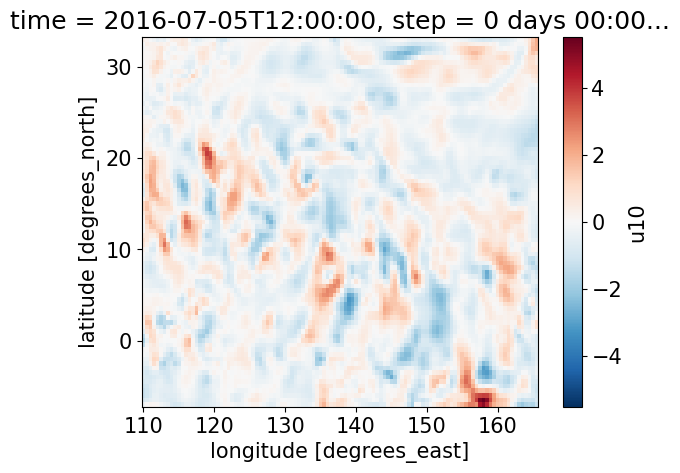

In [30]:
(u10[4] - u10[1]).plot()

In [36]:
add_tc_track = True
# add_tc_track = False
if add_tc_track:
    from tropycal import tracks
    basin = tracks.TrackDataset(basin='west_pacific',source='ibtracs')
    storm = basin.get_storm(('nepartak',2016))
    track = {
        'vmax': storm.vars['vmax'],
        'lon': storm.vars['lon'],
        'lat': storm.vars['lat'],
        # 'lon': storm.vars['wmo_lon'],
        # 'lat': storm.vars['wmo_lat'],
        }

--> Starting to read in ibtracs data
--> Completed reading in ibtracs data (8.4 seconds)


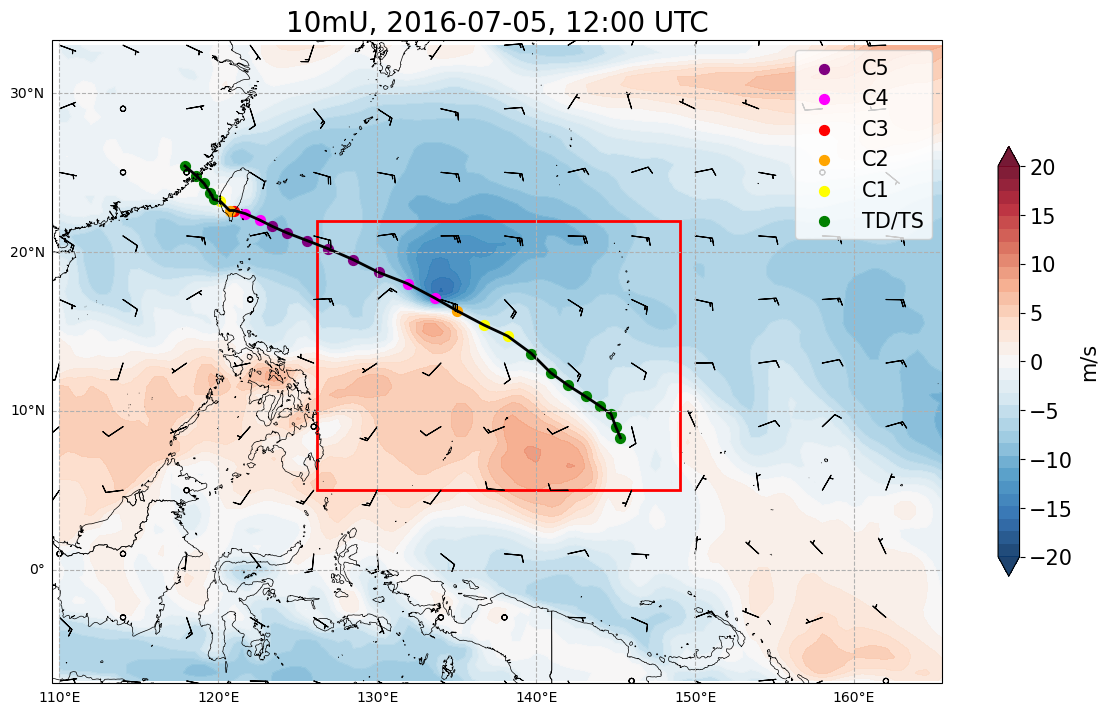

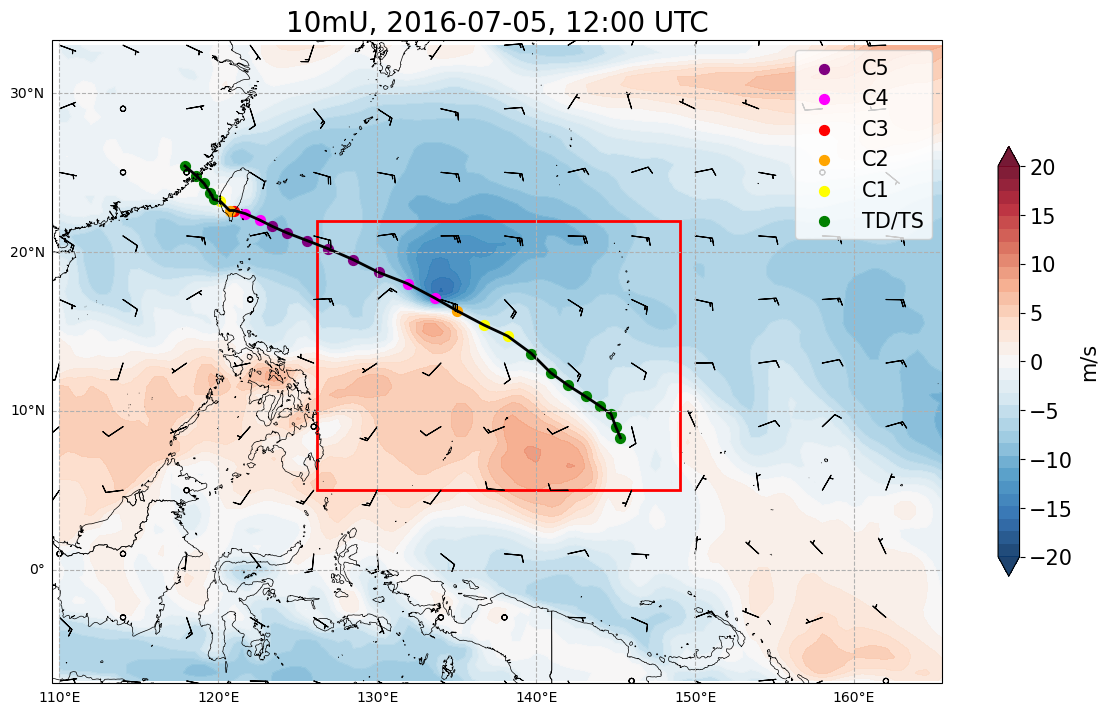

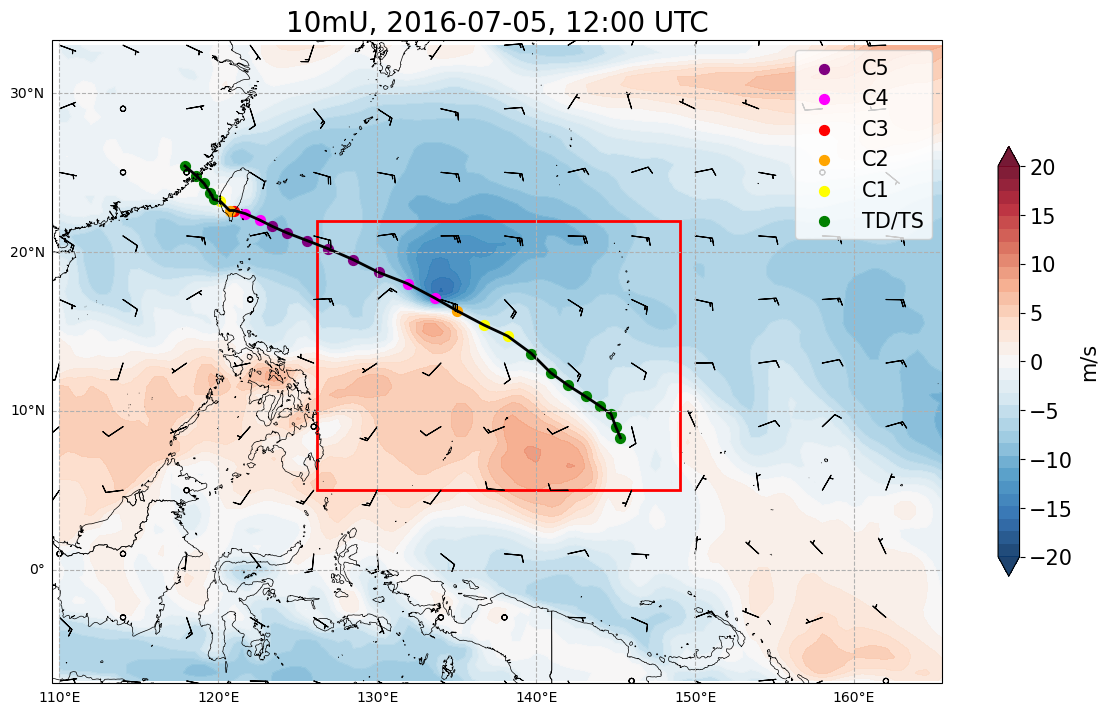

In [37]:
# plt_area=[lon[0,0], lon[0,-1], lat[0,0], lat[-1,0]] # W,E,S,N
# plt_area=[125, 180, 0, 45]
# plt_area=[115, 160, 0, 45]

# D01 area for Nepartak
plt_area=[109.536, 165.555, -7.132, 33.350]
# d02_bounds = np.array([129.44, 155.49, 8.9988, 24.275])
d02_bounds = np.array([126.223, 149.050, 4.984, 21.939])

# nt = file_open['time'].values.shape[0]

itime=36

# for ifile in range(0,nt,12):
for ifile in range(0,3):
    # file_open = xr.open_mfdataset(grib_files[ifile], engine="cfgrib")
    # for var_name in ["OLR", "MRef", "900-600Thick"]:
    for var_name in ["U"]:
        # print("Plotting ", var_name, " from ", wrffiles[ifile], " at ", it_read)
        # run_plot(var_name, grib_files[ifile], 0, plt_area)
        run_plot(var_name, files_open[ifile], 0, plt_area, itime=itime, track=track, d02_bounds=d02_bounds)
    # file_open.close()

#### TROPYCAL plots

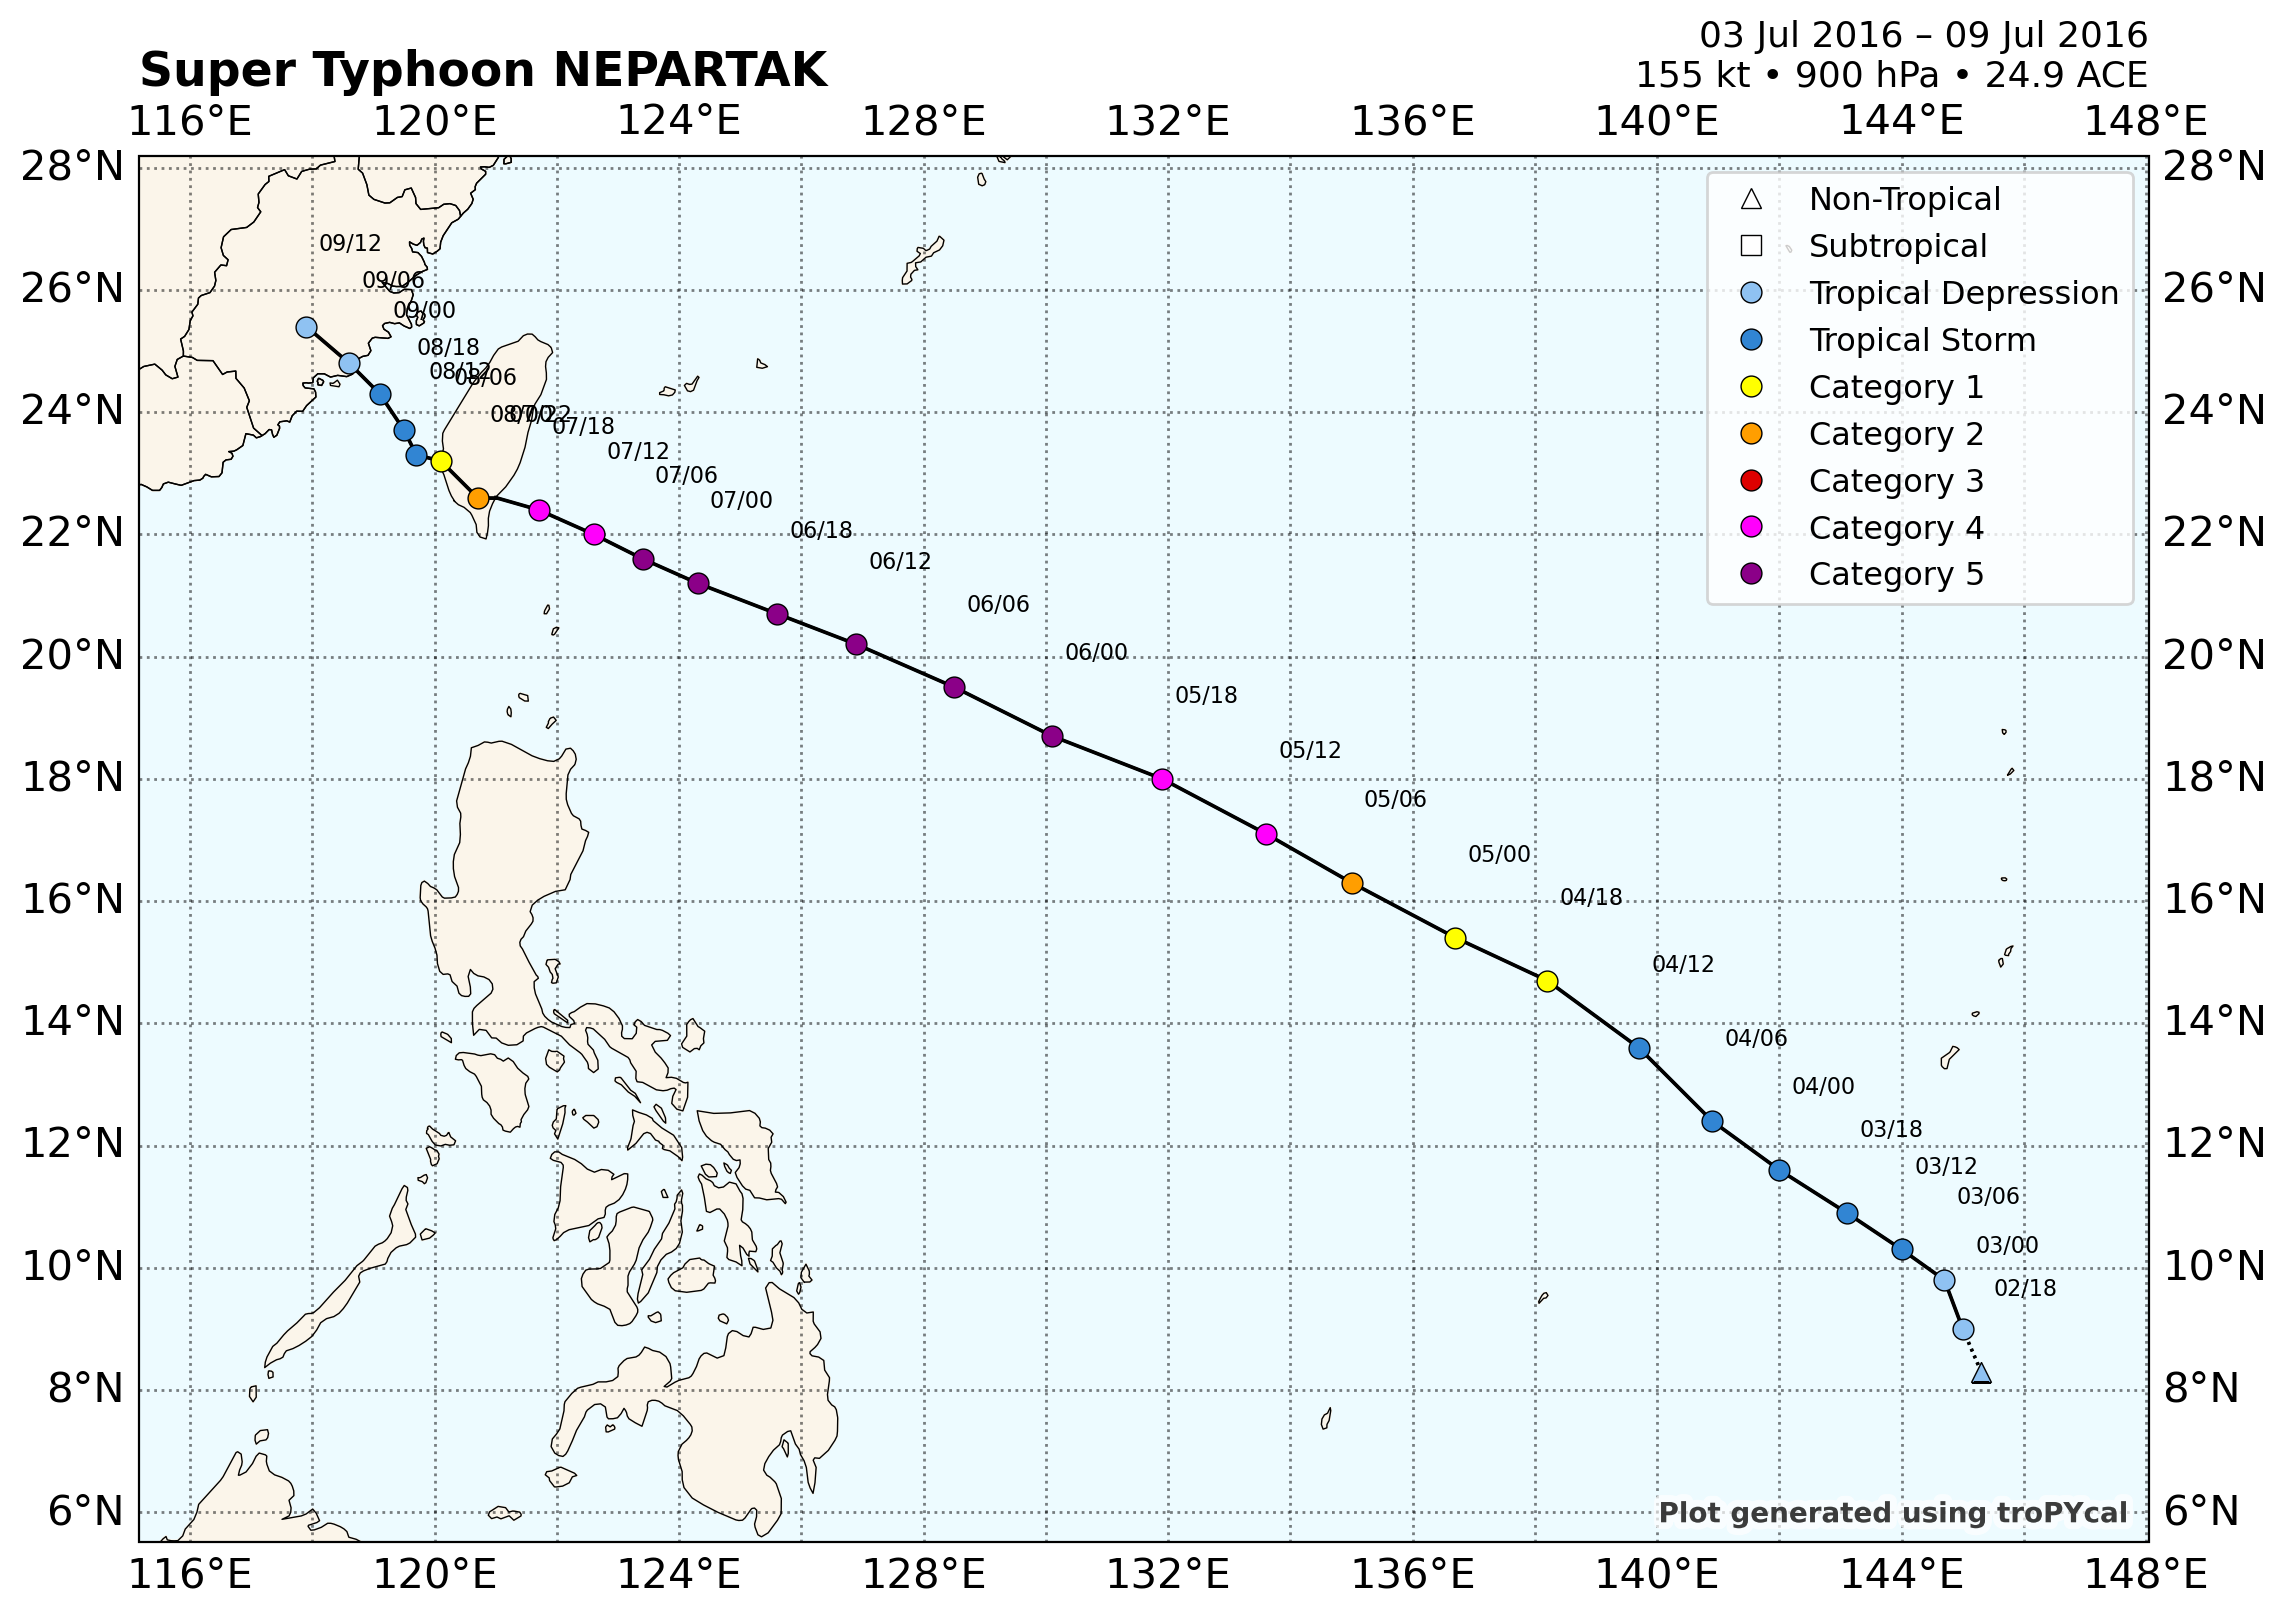

In [162]:
ax = storm.plot()

# Extract time and coordinates data
times = storm['time']
buffer = 1.25
lats = storm['lat']+buffer
# lons = storm['lon']-180+buffer
lons = storm['lon']+buffer

# Add date annotations to the plot
for i, (time, lat, lon) in enumerate(zip(times, lats, lons)):
    ax.text(lon, lat, time.strftime('%d/%H'), fontsize=8, ha='right')

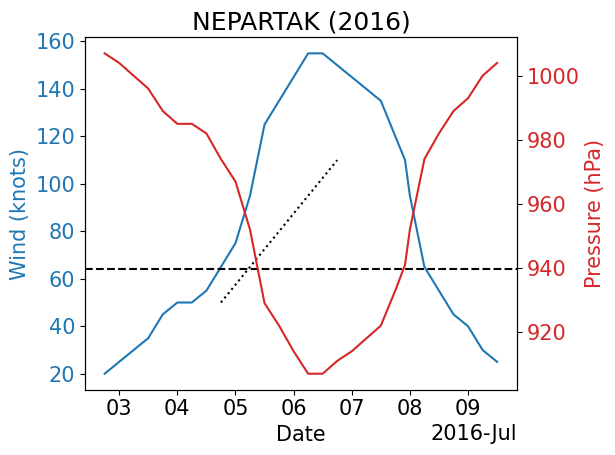

In [156]:
import matplotlib.dates as mdates

# Extract time, pressure, and wind data
times = storm['time']
pressures = storm['mslp']
winds = storm['vmax']

# Create a figure and axis
fig, ax1 = plt.subplots()

ax1.xaxis.set_major_locator(mdates.AutoDateLocator())
ax1.xaxis.set_major_formatter(mdates.ConciseDateFormatter(ax1.xaxis.get_major_locator()))

# Plot wind data
ax1.set_xlabel('Date')
ax1.set_ylabel('Wind (knots)', color='tab:blue')
ax1.plot(times, winds, color='tab:blue', label='Wind')
ax1.tick_params(axis='y', labelcolor='tab:blue')

# Add horizontal line for Category 1 hurricane
ax1.axhline(y=64, color='black', linestyle='--', label='Category 5')

# Plot a line given two end points
dt = np.array((times[5] - times[4]), dtype='timedelta64[h]')
x0, y0 = np.datetime64(times[8]), 50
rapid_int = 30
x1, y1 = x0+np.timedelta64(2, 'D'), y0 + rapid_int*2
ax1.plot([x0, x1], [y0, y1], color='black', linestyle=':', label='RI')

# Create a second y-axis to plot pressure data
ax2 = ax1.twinx()
ax2.set_ylabel('Pressure (hPa)', color='tab:red')
ax2.plot(times, pressures, color='tab:red', label='Pressure')
ax2.tick_params(axis='y', labelcolor='tab:red')

# Add a title and show the plot
plt.title(storm['name']+' ('+str(storm['year'])+')')
fig.tight_layout()
plt.show()